In [59]:
import numpy as np
import matplotlib.pyplot as plt

my_seed = 10101
np.random.seed(my_seed)

In [60]:
def neg_exp(lsp, alpha, delta):
    return (1 + alpha) * np.exp(-np.abs(lsp)) + delta

def rev_abs_x(lsp, alpha, delta):
    return (1 + alpha) / (np.abs(lsp) + 1) + delta

In [61]:
x = np.linspace(-5, 5, 100)
ts_ne = []
ts_rax = []
for i in range(10):
    alpha = np.random.randint(-5000, 5001) * 0.0001
    delta = np.random.randint(-500, 501, len(x)) * 0.0001
    ts_ne.append(neg_exp(x, alpha, delta))
    delta = np.random.randint(-500, 501, len(x)) * 0.0001
    ts_rax.append(rev_abs_x(x, alpha, delta))
ts_ne = np.array(ts_ne)
ts_rax = np.array(ts_rax)

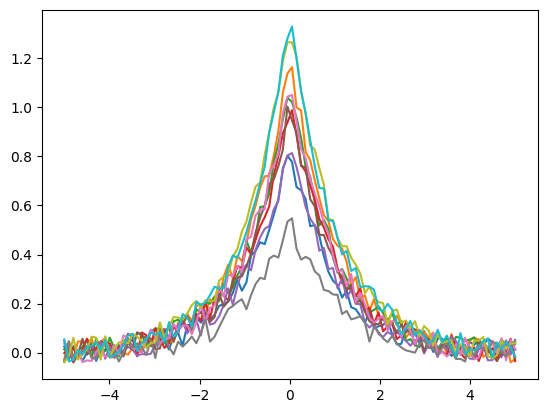

In [62]:
for ts in ts_ne:
    plt.plot(x, ts)
plt.show()

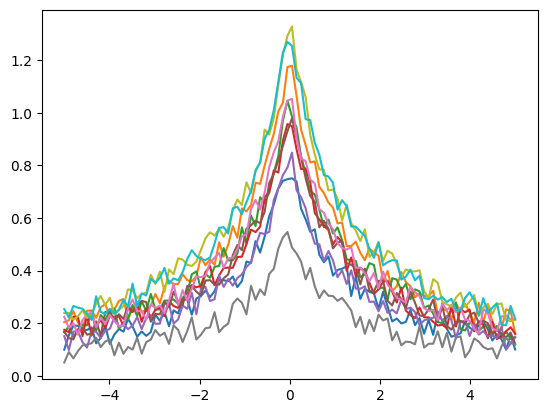

In [63]:
for ts in ts_rax:
    plt.plot(x, ts)
plt.show()

In [64]:
tsarr = [[ts_ne, 0], [ts_rax, 1]]

In [65]:
def sum_one_to_n(n):
    return int(n * (n + 1) / 2)

def sum_k_to_n(k, n):
    return sum_one_to_n(n) - sum_one_to_n(k - 1)

In [66]:
def euclidean_distances(x, y):
    return np.sqrt(np.sum((x - y) * (x - y)))

def min_dist(x, y):
    return np.min([euclidean_distances(x, y[i:i + len(x)]) for i in np.arange(len(y) - len(x) + 1)])

In [67]:
def assess_quality(shapelet, ds, c):
    total = np.zeros(c)
    for ts in ds:
        total[ts[1]] += 1
    p_total = -np.sum([np.log(np.power(total[i] / len(ds), total[i] / len(ds))) for i in np.arange(len(total))])
    left = np.zeros(c)
    right = np.zeros(c)
    for ts in ds:
        right[ts[1]] += 1
    ig = p_total # this seems to be the information gain if split point is placed before the first element
    for i in range(1, len(ds)):
        left[ds[i - 1][1]] += 1
        right[ds[i - 1][1]] -= 1
        #p_left = -np.sum([total[i] / len(ds) * np.log(total[i] / len(ds)) for i in np.arange(len(total))])
        #p_right = -np.sum([total[i] / len(ds) * np.log(total[i] / len(ds)) for i in np.arange(len(total))])
        p_left = np.sum([np.log(np.power(left[i] / len(ds), left[i] / len(ds))) for i in np.arange(len(left))])
        p_right = np.sum([np.log(np.power(right[i] / len(ds), right[i] / len(ds))) for i in np.arange(len(right))])
        ig = max(ig, p_left * i / len(ds) + p_right * (len(ds) - i) / len(ds))
    return p_total + ig

In [68]:
def shapelet_cached_selection(arr, mnm, mxm):
    class Shapelet:
        def __init__(self, values, left, right):
            self.values = values
            self.left = left
            self.right = right

    
    k = 0
    for ts_mark in arr:
        for ts in ts_mark[0]:
            k += sum_k_to_n(len(ts) - mxm + 1, len(ts) - mnm + 1)
    k = int(k * 0.001) # top 0.1% best shapelets for each time series
    print(k)
    print(k)
    print(k)
    k_shapelets = []
    c = len(arr)
    for ts_mark in arr:
        for ts in ts_mark[0]:
            shapelets = []
            ts_len = len(ts)
            for l in range(mnm, mxm + 1):
                for i in range(ts_len - l + 1):
                    shapelet = Shapelet(ts[i:i + l], i, i + l - 1)
                    ds = []
                    for i in range(len(arr)):
                        for j in range(len(arr[i][0])):
                            ds.append([min_dist(shapelet.values, arr[i][0][j]), arr[i][1]])
                    ds = sorted(ds, key=(lambda x: x[0]))
                    quality = assess_quality(shapelet.values, ds, c)
                    shapelets.append([quality, shapelet])
            print(len(shapelets))
            shapelets = sorted(shapelets, key=(lambda x: -x[0]))
            i = 1
            ids = []
            for i in range(len(shapelets)):
                f = True
                for j in ids:
                    flr = shapelets[i][1].right <= shapelets[j][1].left
                    frl = shapelets[j][1].right <= shapelets[i][1].left
                    f = f and (frl or flr)
                    if not(f):
                        break
                if f:
                    ids.append(i)
            for i in ids:
                k_shapelets.append(shapelets[i])
    k_shapelets = sorted(k_shapelets, key=(lambda x: x[0]))[:k]
    return (lambda x: np.array([x[i][1].values for i in np.arange(len(x))]))(k_shapelets)

In [69]:
shapelets = shapelet_cached_selection(tsarr, 15, 75)

68
68
68
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416
3416


68


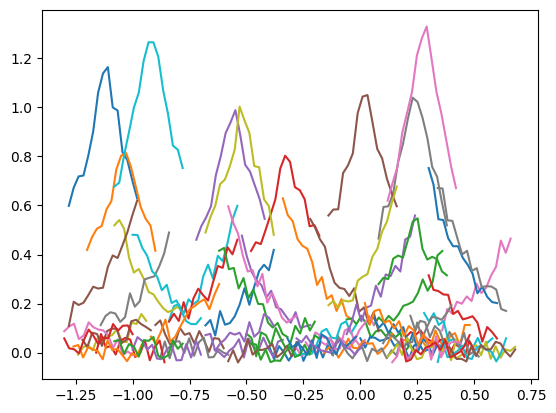

In [70]:
print(len(shapelets))
for s in shapelets:
    t = np.random.randint(100 - len(s))
    plt.plot(np.linspace((t - len(s) - 50) / 50, (t - 50) / 50, len(s)), s)
plt.show()

In [71]:
X = []
y = []
ts_ext = []
for x in tsarr[0][0]:
    ts_ext.append(np.array([min_dist(s, x) for s in shapelets]))
for x in tsarr[1][0]:
    ts_ext.append(np.array([min_dist(s, x) for s in shapelets]))
for i in range(len(ts_ext)):
    X.append(ts_ext[i])
    y.append(i // 10)

X_train = []
X_test = []
y_train = []
y_test = []

indices = np.arange(len(y))
np.random.shuffle(indices) 
for i in range(14):
    X_train.append(X[indices[i]])
    y_train.append(y[indices[i]])

for i in range(14, 20):
    X_test.append(X[indices[i]])
    y_test.append(y[indices[i]])


print(y_train)
print(y_test)

[0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0]
[1, 0, 1, 0, 0, 1]


In [73]:
from pyts.classification import TimeSeriesForest
 
clf = TimeSeriesForest()
clf.fit(X_train, y_train)

print("--- Классификатор TimeSeriesForest ---\n")
print(f"Accuracy = {clf.score(X_test, y_test)}")
for i in range(len(X_test)):
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[i].reshape(1, -1))}")
    print(f"Истинный класс для предсказаний {y_test[i]}\n")

--- Классификатор TimeSeriesForest ---

Accuracy = 1.0
Вектор вероятности принадлежности к классам [[0.29 0.71]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0.968 0.032]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[0.026 0.974]]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [[0.938 0.062]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[0.984 0.016]]
Истинный класс для предсказаний 0

Вектор вероятности принадлежности к классам [[0.012 0.988]]
Истинный класс для предсказаний 1

